In [273]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import uproot as ur,glob, os,awkward as ak


plt.rcParams["figure.figsize"] = (10, 8)

In [207]:
def get_df(filename,nevents=1e7, Eb=5):
    with open(filename, "r") as f:
        d={"Q2":[], "x":[], "pT1":[], "pT2":[], "y1":[], "y2":[], "z1":[], "z2":[], "phi1":[], "phi2":[],
          "p1":[], "p2":[], "thetalab1":[], "thetalab2":[],"philab1":[], "philab2":[],}
        d_lead={"Q2":[], "x":[], "pT1":[], "y1":[], "z1":[], "phi1":[],
          "p1":[],  "thetalab1":[],"philab1":[],}
        pT2s=[]
        phi2s=[]
        y2s=[]
        z2s=[]
        p2s=[]
        thetalab2s=[]
        philab22s=[]
        foundLeading=False
        events=0
        while True:
            line=f.readline()
            if line is not None:
                s=line.split()
            else : break
            if events>nevents:
                break
            if len(s)==0:
                break
            if "Event finished" in line:
                nh2=len(pT2s)
                if foundLeading==True:
                    
                    d_lead['Q2'].append(Q2)
                    d_lead['x'].append(x)
                    d_lead['pT1'].append(pT1)
                    d_lead['y1'].append(y1)
                    d_lead['z1'].append(z1)
                    d_lead['p1'].append(p1)
                    d_lead['thetalab1'].append(thetalab1)
                    d_lead['philab1'].append(philab1)
                    d_lead['phi1'].append(phi1)
                    if nh2 >0:
                        d['Q2']+=[Q2]*nh2
                        d['x']+=[x]*nh2
                        d['pT1']+=[pT1]*nh2
                        d['y1']+=[y1]*nh2
                        d['z1']+=[z1]*nh2
                        d['p1']+=[p1]*nh2
                        d['thetalab1']+=[thetalab1]*nh2
                        d['philab1']+=[philab1]*nh2
                        d['phi1']+=[phi1]*nh2
                        d['pT2']+=pT2s
                        d['y2']+=y2s
                        d['z2']+=z2s
                        d['phi2']+=phi2s
                        d['p2']+=p2s
                        d['philab2']+=philab2s
                        d['thetalab2']+=thetalab2s
                    foundLeading=False
            elif "====" in line:
                continue
            if s[0]=='0':
                nu=float(s[22])
                Q2=float(s[19])
                x=float(s[20])
                phiLepton=float(s[23])
                phiQ=phiLepton-np.pi
                
                
                # (-E+costhe*E')/q
                # (-E+(1-2sin2the/2)E')/q
                # (-E+(1-Q2/2E'E)E')/q
                thetaQ=np.arccos(-(Q2+2*Eb*nu)/(2*Eb*np.sqrt(Q2+nu**2)))
                
                #reset
                pT2s=[]
                phi2s=[]
                y2s=[]
                z2s=[]
                p2s=[]
                thetalab2s=[]
                philab2s=[]
                foundLeading=False
                events+=1
                continue
            
            if len(s)<5:
                continue
            pid=s[2]
            if not(pid == "211" or pid=="-211"):
                continue
            status=s[1]
            
            px=float(s[7])
            py=float(s[8])
            pz=float(s[9])
            p=np.sqrt(px**2+py**2+pz**2)
            thetalab=np.pi-np.arctan2(np.hypot(px,py),pz)
            philab=np.arctan2(py,px)
            E=float(s[10])
            #print("m=", np.sqrt(E**2-px**2-py**2-pz**2))
            z=E/nu
            #print("z=",z, "nu=", nu)
            
            if status !="1":
                continue
            
            P4=ROOT.TLorentzVector(px,py,pz, E)
            
            P4.RotateZ(-phiQ)
            P4.RotateY(-thetaQ)
            
            Eb=5
            
            
            
            if pid=="211" and z>0.5: #leading pi+
                z1=z
                pT1=P4.Pt()
                phi1=P4.Phi()
                y1=P4.Rapidity()
                p1=p
                thetalab1=thetalab
                philab1=philab
                foundLeading=True
            elif pid=="-211" and z<0.5: #subleading pi-
                z2s.append(z)
                pT2s.append(P4.Pt())
                phi2s.append(P4.Phi())
                y2s.append(P4.Rapidity())
                p2s.append(p)
                thetalab2s.append(thetalab)
                philab2s.append(philab)
            #elif pid=="11":
            #    P4_lab=ROOT.TLorentzVector(-px,-py,-Eb-pz, Eb-E)
            #    print(phiQ, P4_lab.Phi(), thetaQ, P4_lab.Theta())
    return pd.DataFrame(d), pd.DataFrame(d_lead)
            
                

In [293]:
events={}; events_lead={}
import pickle
for A in "D C Fe Pb".split():
    f=f"beagle_output/e{A}_filtered.pkl"
    with open(f, "rb") as f:
        events[A],  events_lead[A]= pickle.load(f)
    print(f"parsed {A}, {len(events[A])} pairs, {len(events_lead[A])} leading")
    
# for A in "D C Fe Pb".split():
#     f=f"beagle_output/e{A}_filtered.txt"
#     events[A],  events_lead[A]= get_df(f, 1e7)
#     print(f"parsed {A}, {len(events[A])} pairs, {len(events_lead[A])} leading")

parsed D, 1626966 pairs, 2242241 leading
parsed C, 1796164 pairs, 2507060 leading
parsed Fe, 1648841 pairs, 2195905 leading
parsed Pb, 1519782 pairs, 1923927 leading


(array([[ 7046.,  8109., 11010., 17068., 26297., 31090., 26069., 17064.,
         11034.,  8016.],
        [ 7900.,  7246.,  7958., 11064., 17062., 25947., 31304., 25888.,
         17019., 10938.],
        [10832.,  8067.,  7345.,  7895., 10823., 16785., 26044., 31618.,
         26034., 17223.],
        [17034., 10961.,  8081.,  7087.,  8173., 10854., 17076., 25887.,
         31353., 26294.],
        [25892., 17326., 11032.,  8035.,  7163.,  7917., 10688., 16895.,
         26207., 31252.],
        [31211., 26156., 17150., 10835.,  8096.,  7154.,  7970., 11027.,
         17147., 26194.],
        [26183., 31311., 26332., 17053., 10902.,  8046.,  7020.,  8089.,
         11100., 17055.],
        [17179., 26260., 31242., 25985., 17072., 10927.,  8007.,  7172.,
          8040., 10959.],
        [10972., 17100., 26143., 31505., 26278., 17113., 10883.,  7913.,
          7256.,  7961.],
        [ 7997., 10956., 16985., 25801., 31210., 26140., 16947., 10961.,
          7836.,  7133.]]),
 array([

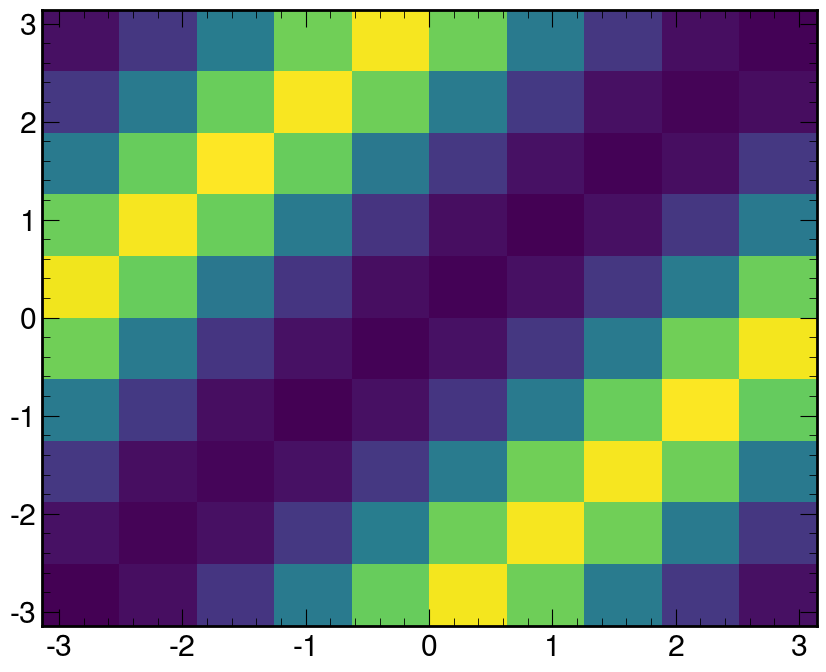

In [294]:
plt.hist2d(events['D'].phi1, events['D'].phi2)

In [295]:
def process(df):
    pi=np.pi
    df['dphi']=df.eval(f"phi1-phi2-(phi1-phi2>{np.pi})*{2*pi}+(phi1-phi2<-{np.pi})*{2*np.pi}")
    df['dy']=df.eval("y1-y2")
    Mp=0.9383
    df['nu']=df.eval(f"Q2/(x*2*{Mp})")
    df['W']=df.eval(f"sqrt({Mp**2}+2*{Mp}*nu-Q2)")
def process_lead(df):
    Mp=0.9383
    df['nu']=df.eval(f"Q2/(x*2*{Mp})")
    df['W']=df.eval(f"sqrt({Mp**2}+2*{Mp}*nu-Q2)")

In [296]:
for A in "D C Fe Pb".split():
    process(events[A])
    process_lead(events_lead[A])

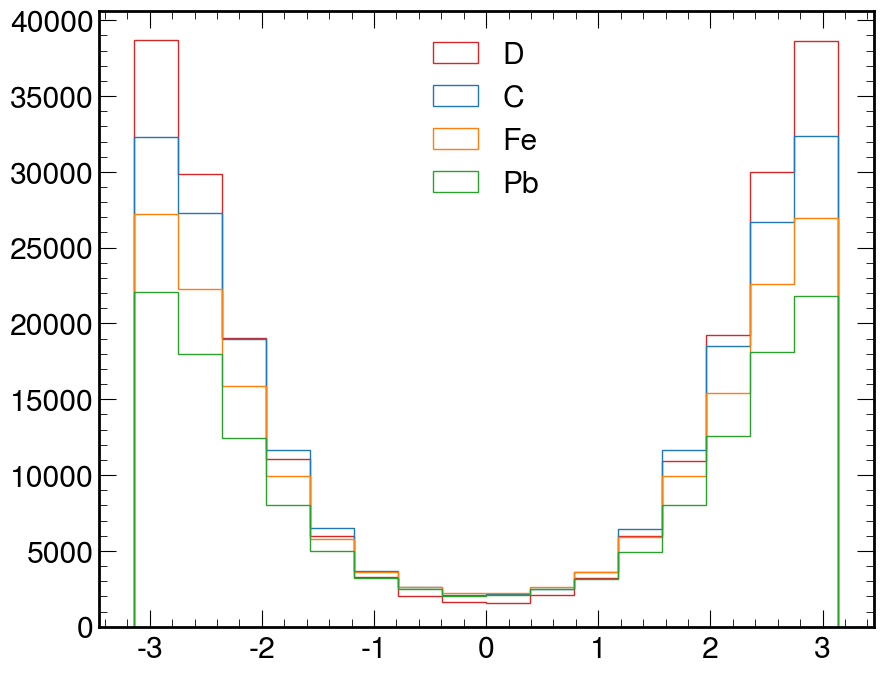

In [297]:
deg=np.pi/180
q=f"pT1>0.25 and pT2>0.25 and Q2>1 and Q2/(x*2*0.9383)>2.2 and Q2/(x*2*0.9383)<4.2 and thetalab1>10*{deg}"
colors='tab:red tab:blue tab:orange tab:green'.split()
for i,A in enumerate("D C Fe Pb".split()):
    plt.hist(events[A].query(q).dphi, bins=np.linspace(-np.pi,np.pi, 17), density=False, histtype='step', 
             label=A, color=colors[i])
    
plt.legend()

In [298]:
deg=np.pi/180
#all_data['all'][0]['D'].C
def getPrediction(q_add=None, q_add_lead=None):
    q=f"pT1>0.25 and pT2>0.25 and Q2>1 and nu>2.2 and nu<4.2 and thetalab1>10*{deg} and W>2"
    q+=f" and ((thetalab2>25*{deg} and p2>0.7) or (thetalab2>30*{deg} and p2>0.5) or (thetalab2>40*{deg} and p2>0.35))"
    q+=f" and z2>0.05 and z2<0.45 and z1>0.5"
    q_lead=f"pT1>0.25 and Q2>1 and nu>2.2 and nu<4.2 and W>2 and thetalab1>10*{deg}"
    if q_add is not None:
        q+= " and " + q_add
    if q_add_lead is not None:
        q_lead+= " and " + q_add_lead
        
    colors='tab:red tab:blue tab:orange tab:green'.split()
    results={}
    for i,A in enumerate("D C Fe Pb".split()):
        #plt.hist(events[A].query(q).dphi, bins=np.linspace(-np.pi,np.pi, 17), density=False, histtype='step', 
        #         label=A, color=colors[i])
        y,x=np.histogram(abs(events[A].query(q).dphi), bins=np.linspace(0,np.pi, 9))
        bc=(x[1:]+x[:-1])/2
        n_lead=len(events_lead[A].query(q_lead))

        width=np.sqrt(np.sum(y*(bc-np.pi)**2)/np.sum(y))
        
        #width=np.sqrt(np.sum(y*(bc-np.pi)**2)/np.sum(y))
        if i==0:
            norm = 2*np.pi/8*sum(y/n_lead)
            width_D=width
        
        #print(width, np.sqrt(width**2-width_D**2))
        
        C=y/n_lead/norm
        dCstat = np.sqrt(y)/n_lead/norm
        phi=bc
        phi_low=x[:-1]
        phi_up=x[1:]

        dwidth=np.sqrt(sum(dCstat**2*(((phi-np.pi)**2-width**2)/sum(C))**2))/(2*width)
        print(A, "%.3f"%width, "+-", "%.3f"%dwidth)
        
        bc=list(bc)+list(reversed(np.pi*2-bc))
        y=np.array(list(y)+list(reversed(y)))

        
        plt.fill_between(bc, (y-np.sqrt(y))/n_lead/norm,  (y+np.sqrt(y))/n_lead/norm,label=A, color=colors[i], alpha=0.5)
        results[A]=pd.DataFrame({'C':C, 'dCstat':dCstat, "phi":phi,"phi_low":phi_low, "phi_up": phi_up})
        results[A]['R'] = results[A]['C']/results['D']['C']
        results[A]['dRstat'] = results[A]['R']*np.hypot(results[A]['dCstat']/results[A]['C'],results['D']['dCstat']/results['D']['C'])
    plt.legend()
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.ylabel("correlation")
    plt.show()
    return results
all_BeAGLE={}

D 1.088 +- 0.003
C 1.234 +- 0.003
Fe 1.263 +- 0.003
Pb 1.287 +- 0.003


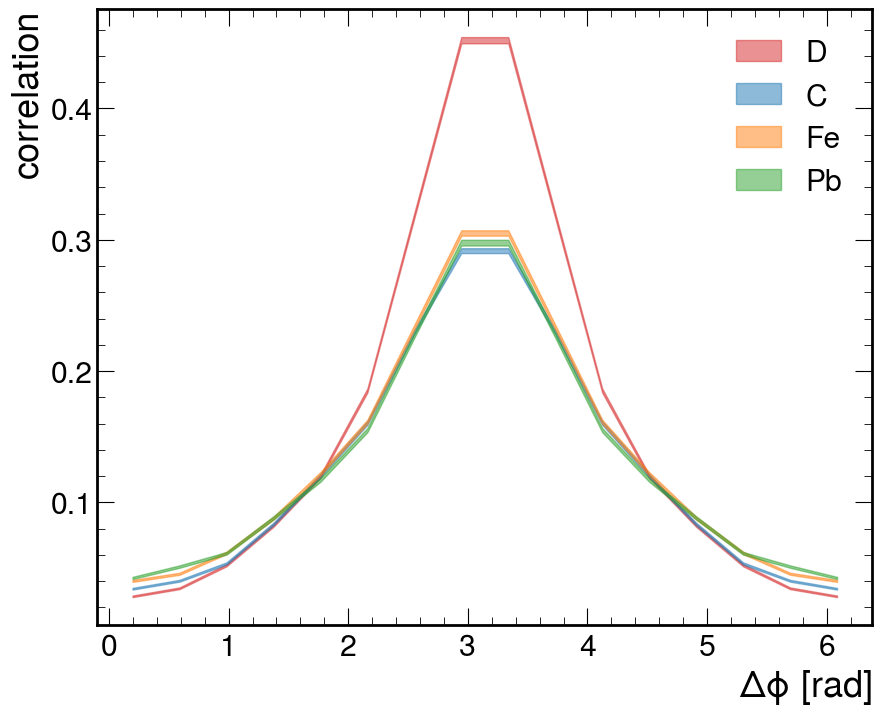

In [299]:
all_BeAGLE['all']=[getPrediction()]

dY bins
D 0.837 +- 0.005
C 0.989 +- 0.006
Fe 0.970 +- 0.007
Pb 0.974 +- 0.008


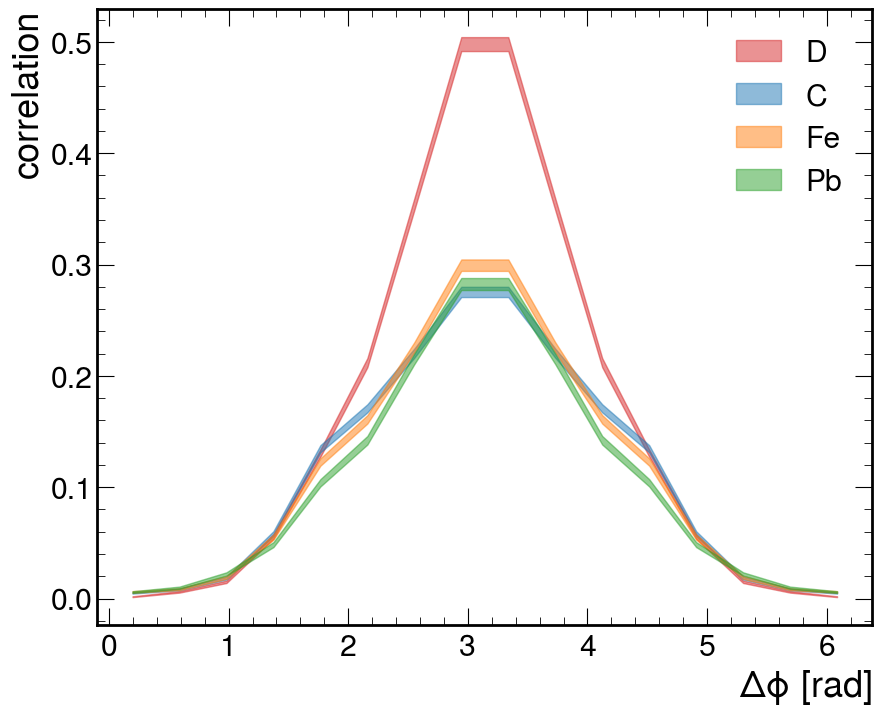

D 1.100 +- 0.003
C 1.243 +- 0.004
Fe 1.254 +- 0.004
Pb 1.274 +- 0.004


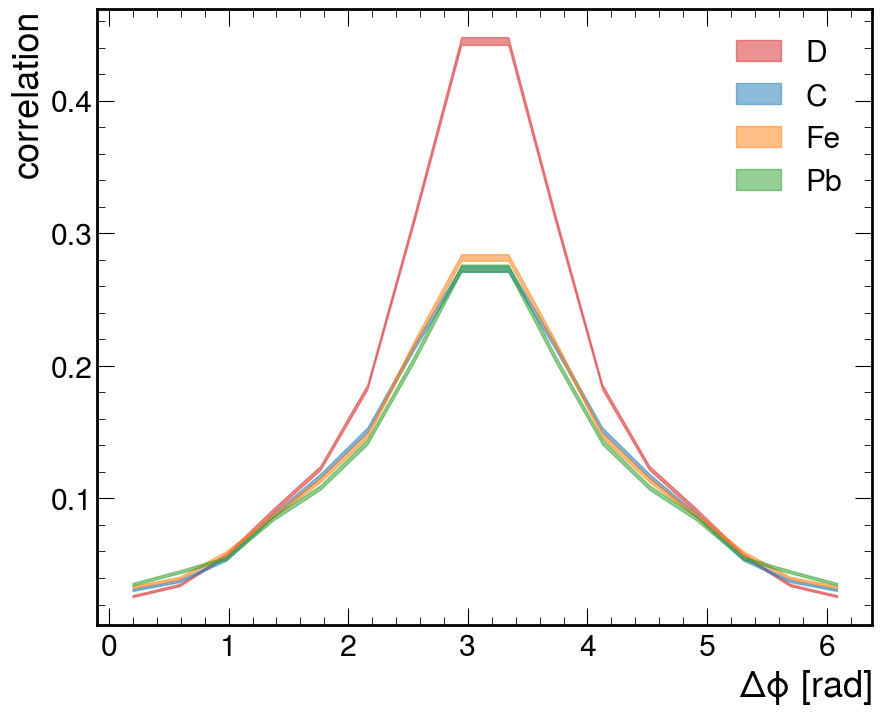

D 1.208 +- 0.006
C 1.323 +- 0.006
Fe 1.394 +- 0.006
Pb 1.414 +- 0.007


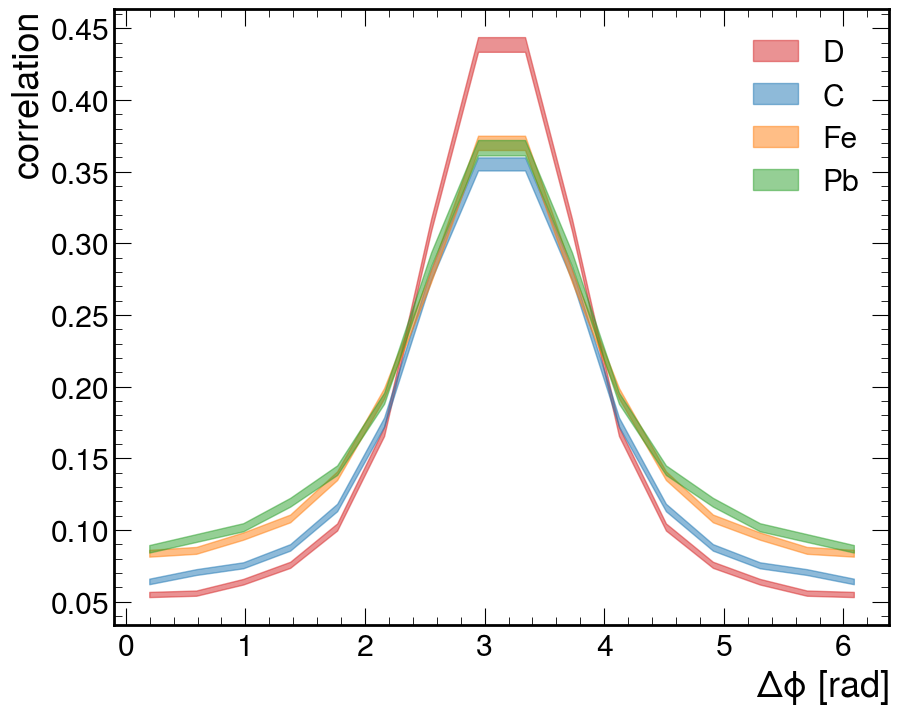

pT1 bins
D 1.452 +- 0.005
C 1.498 +- 0.005
Fe 1.528 +- 0.006
Pb 1.548 +- 0.006


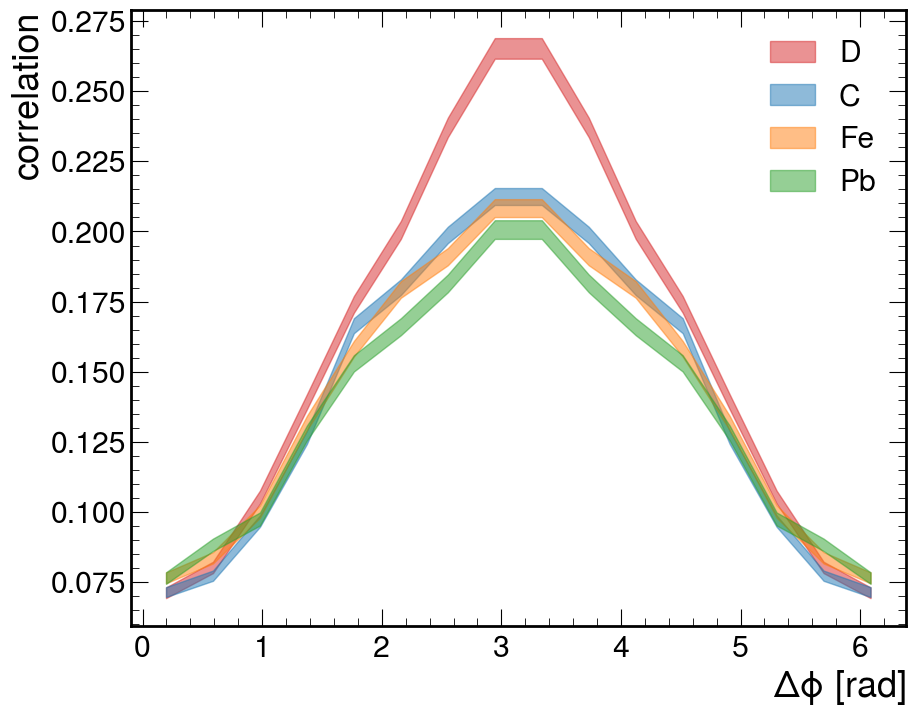

D 1.113 +- 0.004
C 1.218 +- 0.005
Fe 1.262 +- 0.005
Pb 1.290 +- 0.006


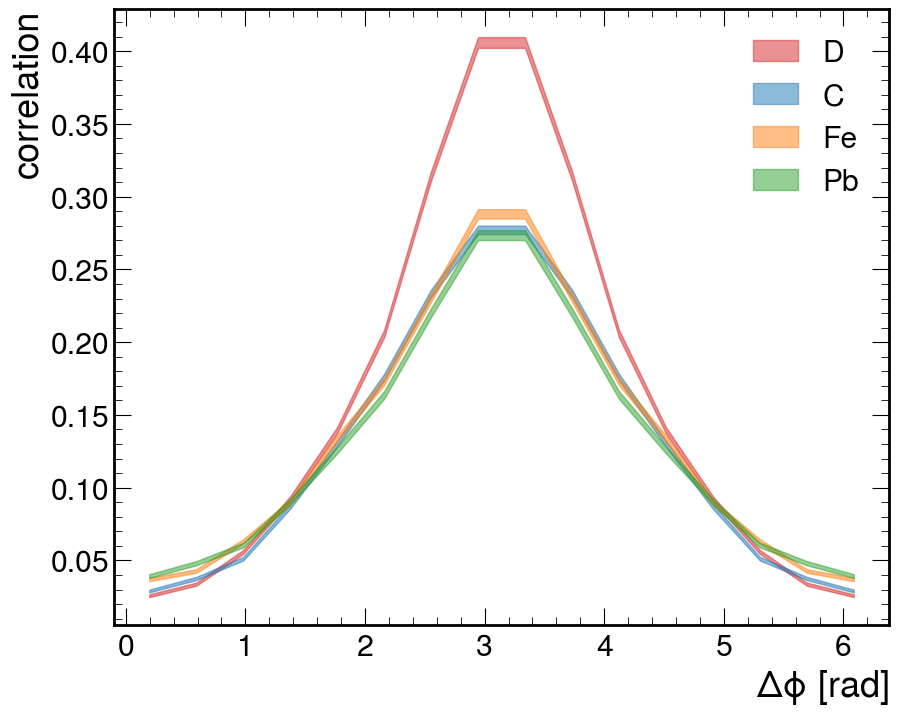

D 0.750 +- 0.004
C 0.909 +- 0.005
Fe 0.949 +- 0.005
Pb 0.970 +- 0.006


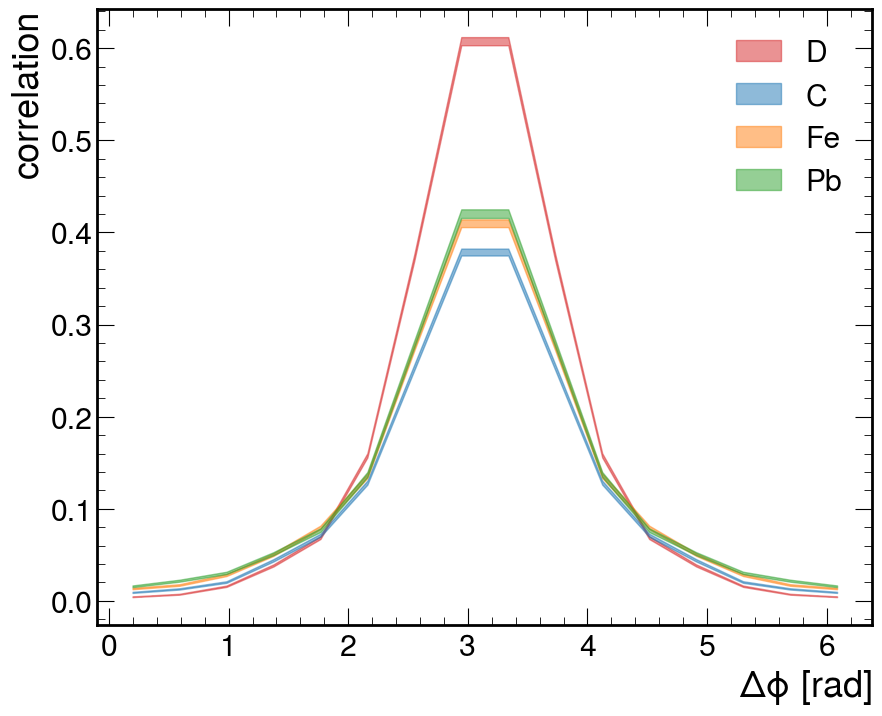

pT2 bins
D 1.102 +- 0.003
C 1.226 +- 0.003
Fe 1.255 +- 0.004
Pb 1.278 +- 0.004


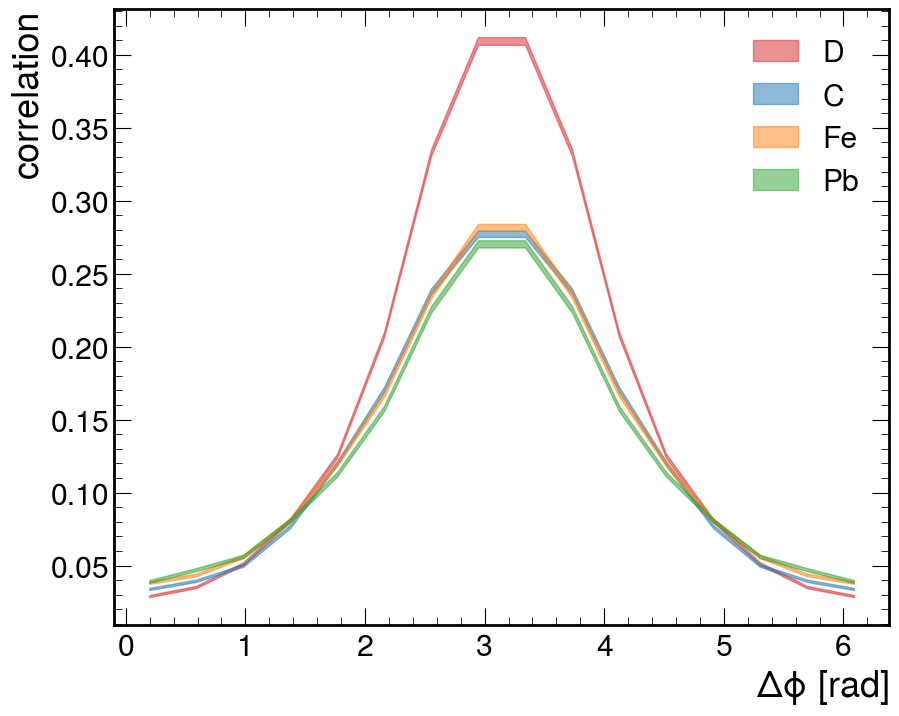

D 1.068 +- 0.005
C 1.274 +- 0.006
Fe 1.296 +- 0.006
Pb 1.320 +- 0.007


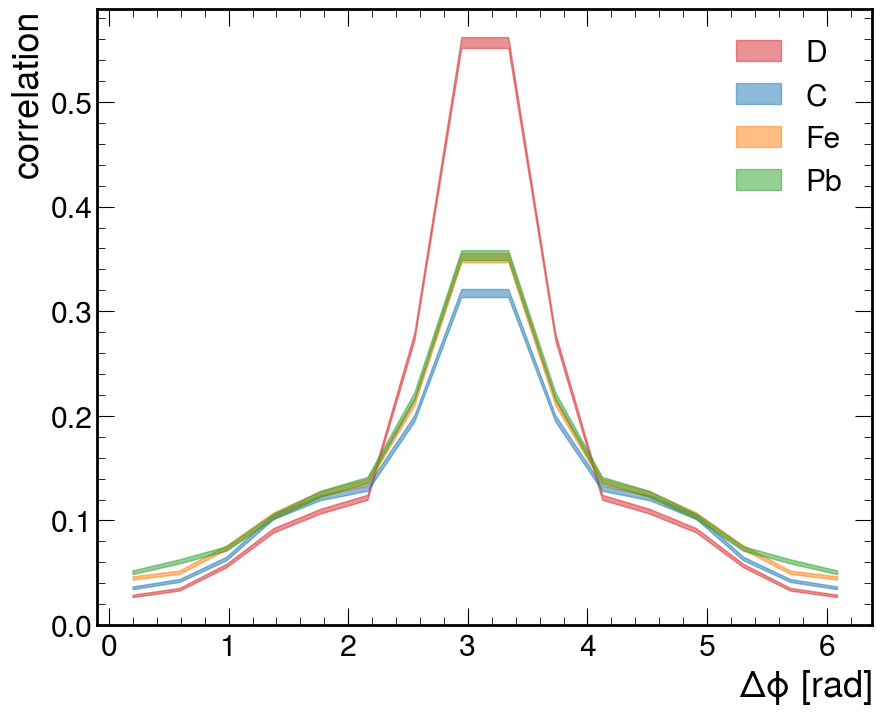

D 0.826 +- 0.018
C 1.101 +- 0.019
Fe 1.191 +- 0.018
Pb 1.243 +- 0.019


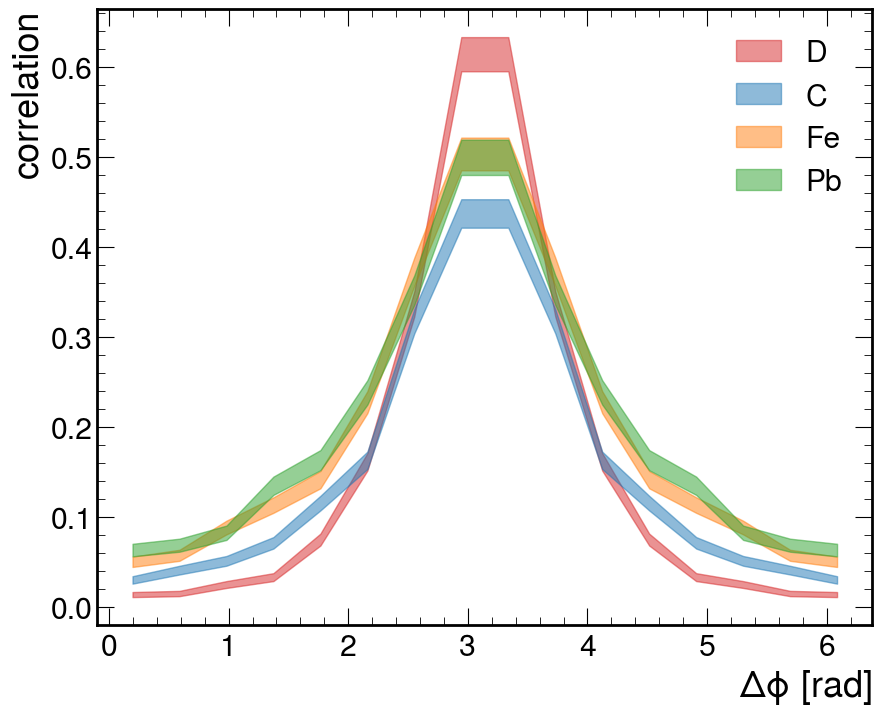

In [300]:
print("dY bins")
all_BeAGLE['dY']=[getPrediction(f"{v1}<dy and dy<{v2}") for v1, v2 in [(-0.5, 0.5), (0.5, 1.5), (1.5, 2.5)]]
print("pT1 bins")
all_BeAGLE['pT1']=[getPrediction(f"{v1}<pT1 and pT1<{v2}", f"{v1}<pT1 and pT1<{v2}") \
                    for v1, v2 in [(0.25, 0.4), (0.4, 0.6), (0.6, 1.0)]]
print("pT2 bins")
all_BeAGLE['pT2']=[getPrediction(f"{v1}<pT2 and pT2<{v2}") for v1, v2 in [(0.25, 0.4), (0.4, 0.6), (0.6, 0.8)]]

In [301]:
import pickle
with open("BeAGLE_results.pkl", "wb") as f:
    pickle.dump(all_BeAGLE, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
plt.hist(events['D'].query(q).eval(f"W"), bins=100)
plt.show()

In [80]:
print(q)

pT1>0.25 and pT2>0.25 and Q2>1 and Q2/(x*2*0.9383)>2.2 and Q2/(x*2*0.9383)<4.2 and thetalab1>10*0.017453292519943295


In [17]:
px,py,pz, E=-0.215292,-0.481621,-1.672567,1.753793

In [22]:
(-((5-E)**2-px**2-py**2-(-5-pz)**2))/(2*.9383*3.24620726941)

0.13333588986699849

In [84]:
f=f"outForPythiaMode/e{A}.root"
help(ur.open(f'{f}:EICTree').arrays(how=dict))

ValueError: cannot produce Awkward Arrays for interpretation AsObjects(AsArray(True, False, AsPointer(Model_erhic_3a3a_ParticleMCeA), ())) because

    arbitrary pointer

instead, try library="np" instead of library="ak" or globally set uproot.default_library

in file outForPythiaMode/eD.root
in object /EICTree;1:event/erhic::EventPythia/erhic::EventMC/particles/particles.eA

In [81]:
a

<TTree 'EICTree' (1 branches) at 0x7f6de26609d0>

In [107]:
P4=ROOT.TLorentzVector(1,2,3,4); help(P4)

Help on TLorentzVector in module ROOT._facade object:

class TLorentzVector(TObject)
 |  Method resolution order:
 |      TLorentzVector
 |      TObject
 |      CPPInstance
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Angle(...)
 |      double TLorentzVector::Angle(const TVector3& v)
 |  
 |  Beta(...)
 |      double TLorentzVector::Beta()
 |  
 |  Boost(...)
 |      void TLorentzVector::Boost(double, double, double)
 |      void TLorentzVector::Boost(const TVector3&)
 |  
 |  BoostVector(...)
 |      TVector3 TLorentzVector::BoostVector()
 |  
 |  Class(...)
 |      static TClass* TLorentzVector::Class()
 |  
 |  Class_Name(...)
 |      static const char* TLorentzVector::Class_Name()
 |  
 |  Class_Version(...)
 |      static short TLorentzVector::Class_Version()
 |  
 |  CosTheta(...)
 |      double TLorentzVector::CosTheta()
 |  
 |  DeclFileLine(...)
 |      static int TLorentzVector::DeclFileLine()
 |  
 |  DeclFileName(...)
 |      static const char* TLorentzVe

In [113]:
p=1
E=1
phiQ=2
thetaQ=3
P4=ROOT.TLorentzVector(p*np.sin(thetaQ)*np.cos(phiQ),
                       p*np.sin(thetaQ)*np.sin(phiQ),
                       p*np.cos(thetaQ), 
                       E)
            
P4.RotateZ(-phiQ)
P4.RotateY(-thetaQ)
P4.X(), P4.Y(), P4.Z(), P4.E()

(-2.7755575615628914e-17, -6.938893903907228e-18, 0.9999999999999999, 1.0)

(array([9.905e+03, 4.109e+03, 1.935e+03, 9.100e+02, 4.000e+02, 2.220e+02,
        9.200e+01, 4.500e+01, 1.500e+01, 8.000e+00]),
 array([1.00000069, 1.42850086, 1.85700102, 2.28550118, 2.71400135,
        3.14250151, 3.57100167, 3.99950184, 4.428002  , 4.85650217,
        5.28500233]),
 <BarContainer object of 10 artists>)

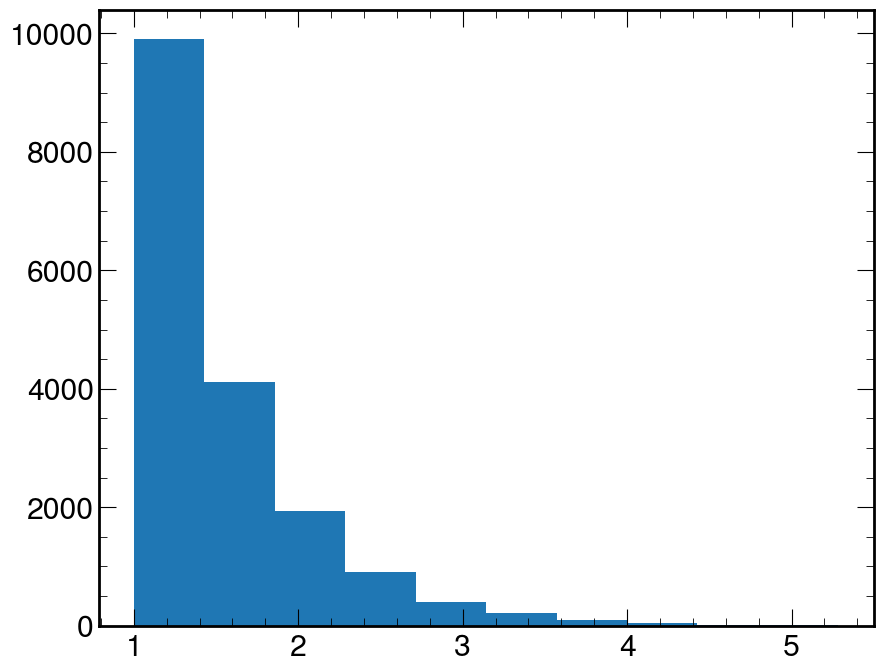

In [204]:
plt.hist(events['D'].Q2)

(array([2.87160e+04, 8.62480e+04, 1.37944e+05, 1.60162e+05, 1.35043e+05,
        8.91240e+04, 5.03680e+04, 2.65690e+04, 1.29540e+04, 5.34400e+03,
        1.90000e+03, 5.61000e+02, 2.42000e+02, 1.37000e+02, 5.90000e+01,
        2.10000e+01, 6.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([7.20885764e-04, 9.92352098e-02, 1.97749534e-01, 2.96263858e-01,
        3.94778182e-01, 4.93292506e-01, 5.91806830e-01, 6.90321154e-01,
        7.88835478e-01, 8.87349802e-01, 9.85864126e-01, 1.08437845e+00,
        1.18289277e+00, 1.28140710e+00, 1.37992142e+00, 1.47843575e+00,
        1.57695007e+00, 1.67546439e+00, 1.77397872e+00, 1.87249304e+00,
        1.97100737e+00]),
 <BarContainer object of 20 artists>)

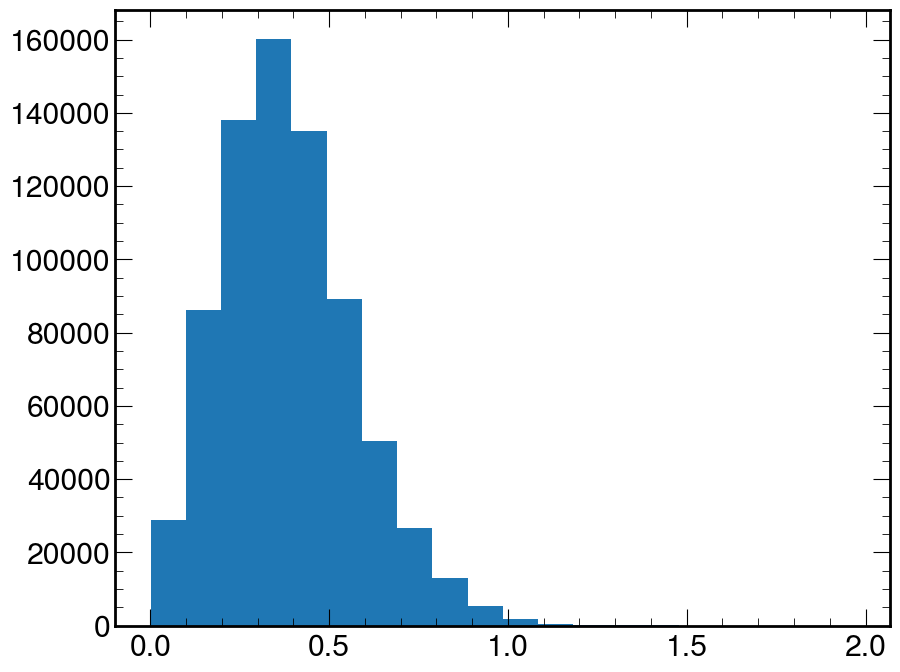

In [306]:
plt.hist(events['C'].query('pT2>0.25').pT1, bins=20)